### Prepare landcover input for discretization ###
Prepare landcover input data for the domain area. This step includes:<br>
1. project large-domain input into a common projection system.
2. extract input for the domain area.
3. resample input according to a reference raster (if needed).
4. classifiy landcover into canopy and non-canopy.
5. check domain landcover and landcover class.

In [1]:
# import libraries
import os, sys 
sys.path.append('../')
import functions.geospatial_analysis as ga
import functions.utils as ut
import rasterio as rio
import rasterio.shutil
from rasterio.warp import Resampling

In [2]:
# common paths
control_file = '../control.tpl.txt'
root_path   = ut.read_from_control(control_file, 'root_path')
source_path = ut.read_from_control(control_file, 'source_path')
domain_name = ut.read_from_control(control_file, 'domain_name')
plot_path   = os.path.join(root_path, 'plot')
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [3]:
# define equal area projection system
new_epsg = ut.read_from_control(control_file, 'epsg') 
dest_crs = rio.crs.CRS.from_epsg(new_epsg)

In [5]:
# large-domain data
landcover_raster     = ut.read_from_control(control_file, 'fulldom_landcover_raster')

# domain data
domain_gru_shp                   = ut.read_from_control(control_file, 'domain_gru_shp')
domain_landcover_raster          = ut.set_filename(control_file, 'domain_landcover_raster') 
domain_landcover_resample_raster = ut.set_filename(control_file, 'domain_landcover_resample_raster')
domain_landcover_class_raster    = ut.set_filename(control_file, 'domain_landcover_class_raster')

# derived filenames
landcover_prj_raster = landcover_raster.split('.tif')[0]+'_prj.tif'
basin_gru_prj_shp    = domain_gru_shp.split('.shp')[0]+'_prj.shp' 

#### 1. Project full-domain landcover #### 

In [5]:
if not os.path.exists(landcover_prj_raster):
    ga.reproject_raster(landcover_raster, landcover_prj_raster, dest_crs, Resampling.nearest) 
print('reprojected landcover raster:', landcover_prj_raster)

reprojected landcover raster: /glade/work/andywood/complexity/source_data/annual_climate_lc_prj.tif


#### 2. Extract domain landcover ####

In [6]:
if not os.path.exists(domain_landcover_raster):
    ga.crop_raster(landcover_prj_raster, domain_gru_prj_shp, domain_landcover_raster) 
print('cropped reprojected landcover raster:', domain_landcover_raster)

cropped reprojected landcover raster: /glade/work/andywood/complexity/basins/bighorn/06282000/landcover.tif


#### 3. Resample domain landcover ####
Resample is only applied to the domain raster that has a coarser resolution than the reference raster. The reference raster is specified by user (by default, it refers to the domain DEM).

In [7]:
refraster = ut.specify_refraster_path(control_file)
ga.resample_raster(basin_landcover_raster, refraster, basin_landcover_resample_raster) 

#### 4. Classify domain landcover into canopy and non-canopy ####
Data source: 20-category IGBP land cover dataset at 1/160 degree resolution (IGBP, 1990). 
Canopy class includes: 1 Evergreen needleleaf forests, 2 Evergreen broadleaf forests, 3 Deciduous needleleaf forests, 4 Deciduous broadleaf forests, 5 Mixed forests, 6 Closed shrublands, 8 Woody savannas. 

In [8]:
ga.classify_landcover(basin_landcover_resample_raster, basin_landcover_class_raster)

#### 5a. Check domain landcover ####

data_unique: [ 0  1  3  5  6  7  8  9 10 11 12 13 14 16]
data_counts: [  6274 196832   2744    238    105   4483  12357   2932 468688   3915
   3547   1002     55    328]
length data_unique: 14
legend_labels: {0: ['black', 'Unspecified'], 1: ['darkgreen', 'Evergreen needleleaf forests'], 3: ['forestgreen', 'Deciduous needleleaf forests'], 5: ['lightgreen', 'Mixed forests'], 6: ['olivedrab', 'Closed shrublands'], 7: ['darkseagreen', 'Open shrublands'], 8: ['goldenrod', 'Woody savannas'], 9: ['gold', 'Savannas'], 10: ['mediumaquamarine', 'Grasslands'], 11: ['powderblue', 'Permanent wetlands'], 12: ['darkorange', 'Croplands'], 13: ['lightcoral', 'Urban and built-up lands'], 14: ['bisque', 'Cropland/natural vegetation mosaics'], 16: ['grey', 'Barren']}
key, color, label: 0 black Unspecified
key, color, label: 1 darkgreen Evergreen needleleaf forests
key, color, label: 3 forestgreen Deciduous needleleaf forests
key, color, label: 5 lightgreen Mixed forests
key, color, label: 6 olivedrab Clo

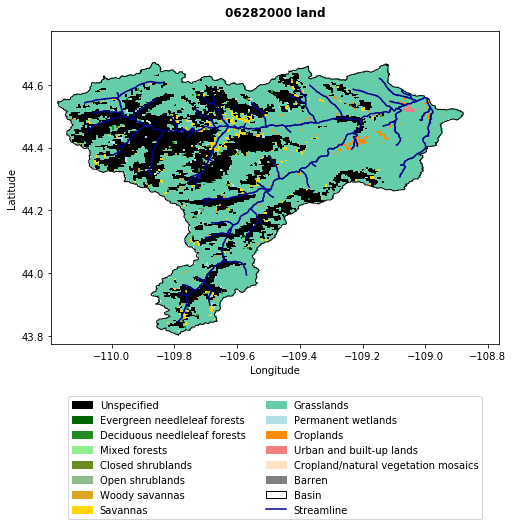

In [9]:
import functions.geospatial_plot as gp
import functions.geospatial_analysis as ga

domain_stream_shp = ut.specify_file_path(control_file, 'domain_stream_shp')

wgs_epsg  = 4326
figsize=(12,12*0.6) # width, height in inches
title = domain_name.capitalize()+' land'
leg_ncol=2
leg_loc='upper center'
leg_bbox_to_anchor=(0.5,-0.15)
  
# IGBP classifications
legend_dict={0:["black", "Unspecified"],
             1:["darkgreen", "Evergreen needleleaf forests"],
             2:["green", "Evergreen broadleaf forests"],
             3:["forestgreen", 'Deciduous needleleaf forests'],
             4:["limegreen", 'Deciduous broadleaf forests'], 
             5:["lightgreen", 'Mixed forests'], 
             6:["olivedrab", 'Closed shrublands'], 
             7:["darkseagreen", 'Open shrublands'], 
             8:["goldenrod", 'Woody savannas'], 
             9:["gold", 'Savannas'], 
             10:["mediumaquamarine", 'Grasslands'], 
             11:["powderblue", 'Permanent wetlands'], 
             12:["darkorange", 'Croplands'], 
             13:["lightcoral", 'Urban and built-up lands'], 
             14:["bisque", 'Cropland/natural vegetation mosaics'], 
             15:["snow", 'Snow and ice'], 
             16:["grey", 'Barren'], 
             17:["royalblue", 'Water bodies']} 

# set plot name and color choice
output_fig_file = os.path.join(plot_path, 'landcover_and_bound_stream.png')   
cmap_str='user'

# plot land cover classes
# (something is wrong with the categories shown in the plot but the categories appear to be ok from the data)
gp.plot_raster_and_bound_stream(domain_landcover_resample_raster,domain_gru_prj_shp,domain_stream_shp,wgs_epsg,cmap_str,
                                legend_dict, figsize,title,leg_loc,leg_bbox_to_anchor,leg_ncol,output_fig_file)

In [ ]:
#### 5b. Check domain landcover class ####

In [ ]:
#import functions.geospatial_plot as gp
domain_stream_shp = ut.specify_file_path(control_file, 'domain_stream_shp')

wgs_epsg  = 4326
figsize=(12,12*0.6) # width, height in inches
title = domain_name.capitalize()+' land class'
leg_ncol=2
leg_loc='upper center'
leg_bbox_to_anchor=(0.5,-0.15)
legend_dict={1:["black", "Canopy"],
             2:["whitesmoke", "Non-canopy"]} 

# set plot name and color choice
output_fig_file = os.path.join(plot_path, 'canopy_class_and_bound_stream.png')   
cmap_str='user'

# plot canopy vs no-canopy decision
gp.plot_raster_and_bound_stream(domain_landcover_class_raster, domain_gru_prj_shp, domain_stream_shp,
                                wgs_epsg, cmap_str, legend_dict, figsize, title, leg_loc, leg_bbox_to_anchor, leg_ncol, output_fig_file)